In [1]:
# append rxn_yield_context to the PYTHONPATH
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm
import pandas as pd

new_path = 'D:\\Retro\\rxn_yield_context'
sys.path.append(new_path)
print(sys.path)


C:\Users\sun73\anaconda3\envs\old_py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\sun73\anaconda3\envs\old_py37\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\sun73\anaconda3\envs\old_py37\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


['D:\\Retro\\rxn_yield_context\\rxn_yield_context\\analyze', 'C:\\Users\\sun73\\anaconda3\\envs\\old_py37\\python37.zip', 'C:\\Users\\sun73\\anaconda3\\envs\\old_py37\\DLLs', 'C:\\Users\\sun73\\anaconda3\\envs\\old_py37\\lib', 'C:\\Users\\sun73\\anaconda3\\envs\\old_py37', '', 'C:\\Users\\sun73\\anaconda3\\envs\\old_py37\\lib\\site-packages', 'C:\\Users\\sun73\\anaconda3\\envs\\old_py37\\lib\\site-packages\\win32', 'C:\\Users\\sun73\\anaconda3\\envs\\old_py37\\lib\\site-packages\\win32\\lib', 'C:\\Users\\sun73\\anaconda3\\envs\\old_py37\\lib\\site-packages\\Pythonwin', 'C:\\Users\\sun73\\anaconda3\\envs\\old_py37\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\sun73\\.ipython', 'D:\\Retro\\rxn_yield_context']


In [2]:
# Make the {reaxy_id: reaction class} pair dictionary
reaxys_dir = "../../Data_From_Reaxys_Original"
dir_names = ['Diels_Alder', 'Hydrolysis', 'Hydrogenation', 'ReductiveAmination',
            'PausonKhandReaction', 'NegishiCouplings',
            'FischerIndoleSynthesis','Friedel-Crafts_Acylation','Friedel-Crafts_Alkylation','GrignardReaction'] # Change Here
reaxys_id_dict = dict()

def basic_preprocess(data_path):
    keep_index = ['Reaction ID', 'Reaction', 'Temperature (Reaction Details) [C]', 
                  'Yield (numerical)','Reagent', 'Solvent (Reaction Details)']
    data = pd.read_excel(data_path)
    drop_index = list(data.columns)
    for index in list(data.columns):
        if index in keep_index:
            drop_index.remove(index)
    data = data.drop(drop_index,axis=1)
    data = data[:-3] # copyright or something 
    return data
    
file_path = os.path.join(reaxys_dir, dir_names[0])
# a = os.listdir(file_path)
for dir_name in tqdm(dir_names):
    file_path = os.path.join(reaxys_dir, dir_name)
    for i, file_name in enumerate(os.listdir(file_path)):
        data_path = os.path.join(file_path, file_name)
        reaction_set = basic_preprocess(data_path)
        for id_ in reaction_set['Reaction ID']:
            reaxys_id_dict.update({id_:dir_name})


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\sun73\anaconda3\envs\old_py37\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:36<00:00, 21.65s/it]


In [3]:
# Get pre-processed data
from rxn_yield_context.preprocess_data import sort_out_data
def get_data(input_path):
    f = open(input_path, 'r')
    data = f.readlines()
    f.close()
    return sort_out_data(data)

target_dir = "../All_LCC_Data/processed_data_temp_large_new"
train_data = get_data(os.path.join(os.path.join(target_dir, 'For_second_part_model'), 'Splitted_second_train_labels_processed.txt'))
validate_data = get_data(os.path.join(os.path.join(target_dir, 'For_second_part_model'), 'Splitted_second_validate_labels_processed.txt'))
test_data = get_data(os.path.join(os.path.join(target_dir, 'For_second_part_model'), 'Splitted_second_test_labels_processed.txt'))

print('Example of visualization:')
print(reaxys_id_dict[train_data[0][0]])
print(train_data[0])

Example of visualization:
PausonKhandReaction
['29904919', 'CC(=O)OC[C@H]1OC(O)[C@H](OC(C)=O)[C@H]1OC(C)=O.CC#CCN(CC=C)S(=O)(=O)C1=CC=C(C)C=C1', 'CC1=C2CN(CC2CC1=O)S(=O)(=O)C1=CC=C(C)C=C1', [('54', "chloro(1,5-cyclooctadiene)rhodium(I) dimer; 2,2'-bis-(diphenylphosphino)-1,1'-binaphthyl", '5,5-dimethyl-1,3-cyclohexadiene', '75.0')]]


In [4]:
# Get the trained first part model
import torch
from rxn_yield_context.train_multilabel.args_train import TrainArgs_rxn
from rxn_yield_context.train_multilabel.model_utils import Multitask_Multilabel

model_path = "../save_model/MultiTask_temp_large_new/multitask_model_epoch-70.checkpoint"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

state = torch.load(model_path, map_location= device)
args = TrainArgs_rxn()
args.from_dict(vars(state['args']), skip_unsettable=True)
args.device = device

loaded_state_dict = state['state_dict']
model = Multitask_Multilabel(args)
model.to(device)
model.load_state_dict(loaded_state_dict)
model.eval()


Multitask_Multilabel(
  (sigmoid): Sigmoid()
  (ffn_share): Sequential(
    (0): Linear(in_features=8192, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (ffn_reagent): Sequential(
    (0): Linear(in_features=500, out_features=300, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=300, out_features=1043, bias=True)
  )
  (ffn_solvent): Sequential(
    (0): Linear(in_features=500, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=81, bias=True)
  )
  (criterion): FocalLoss()
)

In [68]:
# Get hidden output
from rxn_yield_context.train_multilabel.data_utils import create_rxn_Morgan2FP_concatenate

collected_hidden = {dir_name:[] for dir_name in dir_names}
all_hidden = []
for rxn in tqdm(test_data):
    try:
        reaction_type = reaxys_id_dict[rxn[0]]
    except:
        print(rxn[0])
        continue
    rxn_fp = torch.Tensor(create_rxn_Morgan2FP_concatenate(rxn[1], rxn[2], fpsize = args.fpsize, radius = args.radius))
    rxn_fp = rxn_fp.to(device)
    # hidden_output = model.ffn_share(rxn_fp).cpu().detach().numpy() # joint layer
    # hidden_output = rxn_fp.cpu().detach().numpy() # do nothing
    # hidden_output = model.ffn_solvent[1](model.ffn_solvent[0](model.ffn_share(rxn_fp))).cpu().detach().numpy() # solvent layer
    hidden_output = model.ffn_reagent[1](model.ffn_reagent[0](model.ffn_share(rxn_fp))).cpu().detach().numpy() # reagent layer
    collected_hidden[reaction_type].append(hidden_output)
    all_hidden.append(hidden_output)

all_hidden = np.array(all_hidden)

 37%|████████████████████████████▋                                                | 1916/5141 [00:04<00:05, 625.99it/s]

10332707


 40%|██████████████████████████████▋                                              | 2048/5141 [00:04<00:05, 612.65it/s]

37183549


100%|█████████████████████████████████████████████████████████████████████████████| 5141/5141 [00:09<00:00, 539.35it/s]


[0.1490418  0.10847329 0.05689704]


C:\Users\sun73\anaconda3\envs\old_py37\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  del sys.path[0]


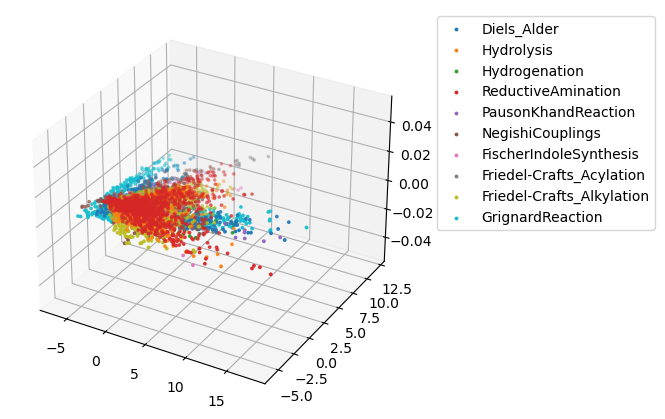

In [69]:
# Perform PCA to reduce dimension
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(all_hidden)
print(pca.explained_variance_ratio_)

import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
#pca.fit_transform()

fig = plt.figure(dpi = 100)
ax = Axes3D(fig)

for key, value in collected_hidden.items():
    df = pd.DataFrame(pca.fit_transform(np.array(value)))
    df['reaction class'] = [key]*len(value)
    ax.scatter(df[0], df[1],s=3, label=key)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#df.head()

[0.14904186 0.10847336]


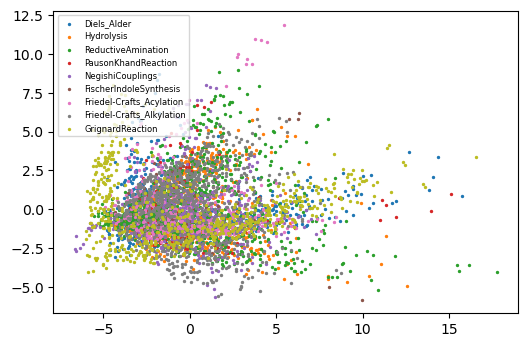

In [70]:
# Perform PCA to reduce dimension
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(all_hidden)
print(pca.explained_variance_ratio_)

import pandas as pd
#pca.fit_transform()

plt.figure(dpi = 100)
for key, value in collected_hidden.items():
    if key in ['Hydrolysis', 'Diels_Alder', 'NegishiCouplings','GrignardReaction' , 'ReductiveAmination',
               'PausonKhandReaction', 'NegishiCouplings',
               'FischerIndoleSynthesis','Friedel-Crafts_Acylation','Friedel-Crafts_Alkylation']:
        df = pd.DataFrame(pca.fit_transform(np.array(value)))
        df['reaction class'] = [key]*len(value)
        plt.scatter(df[0], df[1],s=2, label=key)

plt.legend(loc='upper left',prop={'size': 6})
#df.head()

In [29]:
# Perform t-sne:
from sklearn.manifold import TSNE
for i, (key, value) in enumerate(collected_hidden.items()):
    df_new = pd.DataFrame(np.array(value))
    df_new['reaction class'] = [key]*len(value)
    if i == 0:
        df = df_new.copy()
    else:
        df = df.append(df_new, ignore_index=True)

X_tsne = TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(df.values[:,:-1])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5139 samples in 0.204s...
[t-SNE] Computed neighbors for 5139 samples in 14.444s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5139
[t-SNE] Computed conditional probabilities for sample 2000 / 5139
[t-SNE] Computed conditional probabilities for sample 3000 / 5139
[t-SNE] Computed conditional probabilities for sample 4000 / 5139
[t-SNE] Computed conditional probabilities for sample 5000 / 5139
[t-SNE] Computed conditional probabilities for sample 5139 / 5139
[t-SNE] Mean sigma: 1.784531
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.344971
[t-SNE] KL divergence after 1000 iterations: 1.354103


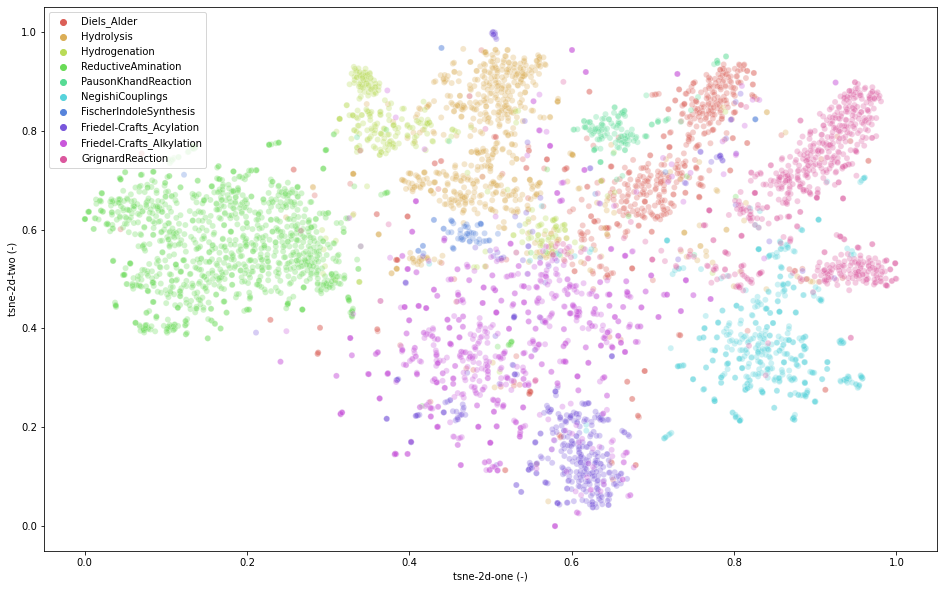

In [30]:
import seaborn as sns


x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize

df_subset = pd.DataFrame()
df_subset['tsne-2d-one (-)'] = X_norm[:, 0]
df_subset['tsne-2d-two (-)'] = X_norm[:, 1]
df_subset['reaction class'] = df['reaction class']

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one (-)", y="tsne-2d-two (-)",
    hue = 'reaction class',
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)
plt.legend(loc='upper left')